# Tully-Fisher Relation of galaxies in the Coma Cluster

Using the observations made as part of the Peculiar Velocity Survey, create the Tully-Fisher relation for those galaxies in the Coma Cluster.

In [1]:
import os

#from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
#from astropy.wcs import WCS
#from astropy.visualization.wcsaxes import SphericalCircle

#import psycopg2

import numpy as np

try:
    import numdifftools as ndt
except ModuleNotFoundError as e:
    ! pip install --user numdifftools
    import numdifftools as ndt
    
from scipy.optimize import minimize, curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)
#mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

## Read in Coma cluster targets

Generated in the `PV_coma_targets` notebook

In [4]:
inComa_sga_table = Table.read('cache/tf_targets_coma_sga.fits', format='fits')

In [6]:
inComa_sga_table[inComa_sga_table['SGA_ID'] == 474614]

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
TFT,474614,1083958997549063,195.029425486026,27.974866852528,0,112,195.029402410274,27.9748750584813,0.0217139702724353,3.73257374494172e-05,GALAXY,2208.77048853108,0,SGA-2020 474614,PGC044708,44708,195.02542950000003,27.9782635,S0,124.36,0.7014553,0.34753618,0.025460279,23.70148,15.843,False,LEDA-20181114,8051,NGC4884_GROUP,9,False,195.04084100953196,27.977352259115825,3.4572668,1951p280,195.0254508437815,27.978308431321093,0.87681913,LEDA,134.53223,0.29138392,195.02536842286858,27.978381200889988,12.795229,-1.0,-1.0,-1.0,15.368808,19.29984,22.665138,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,15.960453,15.227634,14.69586,15.769951,15.044145,14.520126,15.639294,14.919046,14.400259,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.16420102,0.2866459,0.42746606,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.029855765,0.030720465,0.032890983,0.026633546,0.027540786,0.02953706,0.024562325,0.025512308,0.027350776,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
TFT,474614,1083958997549062,195.027415621214,27.9766050440814,0,110,195.027397169164,27.9766173811968,0.0216660631793822,5.53660948171686e-05,GALAXY,1399.09220390924,0,SGA-2020 474614,PGC04

## Calculate the rotational velocities

And store those at $0.33R_{26}$

Also, remove those with a velocity > 5000 km/s

In [11]:
rmag = []
vmax = []
dvmax = []

for i, sga_id in enumerate(np.unique(inComa_sga_table['SGA_ID'])):
    if sga_id == 474614:
        print('skipped')
        continue
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    print
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    r26 = 0.5 * float(sga_galaxy['D26'])*u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))

            rmag.append(float(sga_galaxy['R_MAG_SB26']))
            vmax.append(v033)
            dvmax.append(dv033)
    
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

skipped


80


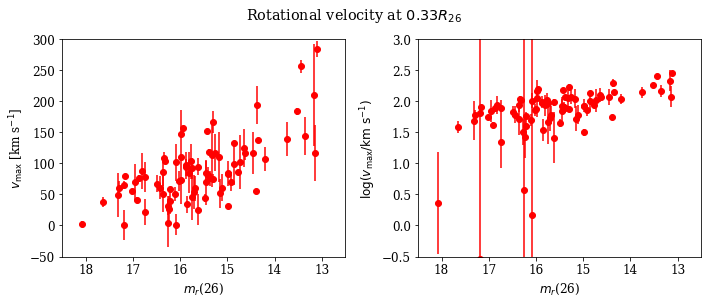

In [10]:
rmag = np.asarray(rmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.33R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

## Cuts on inclination angle and morphology

In [7]:
rmag_clean = []
vmax_clean = []
dvmax_clean = []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

inComa_sga_table['cosi'] = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))
inComa_sga_table['cosi'][np.isnan(inComa_sga_table['cosi'])] = 0 # Objects with b/a < 0.2

#i = 0

for sga_id in np.unique(inComa_sga_table['SGA_ID']):
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    
    morphtype = str(sga_galaxy['MORPHTYPE'])
    
    cosi = float(sga_galaxy['cosi'])
    
    r26 = 0.5 * float(sga_galaxy['D26']) * u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        continue
        
    #i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)

            rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
            vmax_clean.append(v033)
            dvmax_clean.append(dv033)
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()
print(len(rmag_clean))

<ipython-input-7-ffe7595ef809>:8: RuntimeWarning: invalid value encountered in sqrt
  inComa_sga_table['cosi'] = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))


60


## Fitting using `scipy.optimize.minimize`

Segev's code

In [8]:
def l1norm(pars, x, y, dy):
    '''
    Linear fit that uses the l1-norm (robust against outliers).
    '''
    a, b = pars
    return np.sum(np.abs((y - a - b*x)/dy))

def l1norm_noerror(pars, x, y):
    '''
    Linear fit that uses the l1-norm without normalizing by measurement uncertainties.
    '''
    a, b = pars
    return np.sum(np.abs(y - a - b*x))

def l2norm(pars, x, y, dy):
    '''
    Linear fit that uses the l2-norm
    '''
    a, b = pars
    return np.sum((y - a - b*x)**2/dy**2)

def fit_tfr(r, logv, dlogv):
    fmin = 1e99
    a, b = 6, -0.25
    hess_inv = np.ones((2,2))
    
    succ_res = None
    
    # Try a large number of random seeds to ensure a decent fit.
    for i in range(1000):
        _a, _b = np.random.uniform(0,10), np.random.uniform(-1,0)
        
        res = minimize(l1norm_noerror, 
                       [_a, _b], 
                       args=(r, logv),# dlogv),
                       method='L-BFGS-B', 
                       bounds=[[0,10], [-1,1]])
        
        if res.fun < fmin and res.success:
            print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
            hess_inv = res.hess_inv
    
    if succ_res is None:
        print('No successful fits')
    else:
        print(succ_res)
    
    return a, b, hess_inv

Original
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 17.233981232843274, 'jac': array([  1.97915925, -31.60812023]), 'nfev': 333, 'njev': 111, 'nit': 20, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 3.92228727, -0.12923593]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
3.9222872659795045 -0.12923593315563703

Cleaned
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 9.413012091483353, 'jac': array([ -0.48196558, -32.66001498]), 'nfev': 225, 'njev': 75, 'nit': 20, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 4.21110304, -0.14324785]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
4.2111030407169 -0.14324784635332918


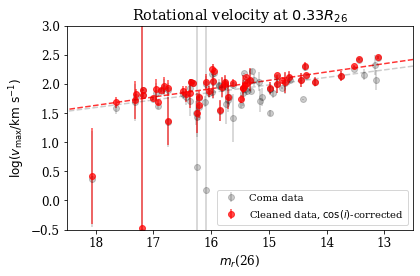

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
print('Original')

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.2,
            label='Coma data')

a, b, _ = fit_tfr(rmag[isrmeas], log10vmax[isrmeas], dlog10vmax[isrmeas])
print(a, b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'k--', alpha=0.2)
################################################################################


################################################################################
# Cleaned data
#-------------------------------------------------------------------------------
print('\nCleaned')

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b, _ = fit_tfr(rmag_clean[isrmeas_clean], 
                  log10vmax_clean[isrmeas_clean], 
                  dlog10vmax_clean[isrmeas_clean])
print(a, b)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)
################################################################################


ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))

### Iteratively fit and remove objects further than 3$\sigma$

In [10]:
def fit_3sigma(x,y,dy):
    '''
    Iterative linear fit that removes points outside 3sigma of the fit until 
    convergence (no more points removed).
    '''
    
    # Number of points to fit
    N = len(x)
    
    # Initialize variable to store the number of points fit in the last iteration
    N_last = np.inf
    
    while (N < N_last) and (N > 1):
        
        # Update N_last
        N_last = N
        
        # Fit
        a, b, hess_inv = fit_tfr(x, y, dy)
        
        ########################################################################
        # Remove all points that are outside 3-sigma of the fit
        #-----------------------------------------------------------------------
        remove_points = []
        
        for i in range(N):
            ####################################################################
            # Calculate expected value at this point
            #-------------------------------------------------------------------
            y_fit = a + b*x[i]
            ####################################################################
            
            
            ####################################################################
            # Calculate sigma at this point
            #-------------------------------------------------------------------
            random_sample = np.random.multivariate_normal(mean=(a,b), 
                                                          cov=hess_inv.matmat(np.eye(2)), 
                                                          size=1000)
            
            y_random = random_sample[:,0] + random_sample[:,1]*x[i]
            
            std_dev = np.std(y_random)
            ####################################################################
            
            
            if np.abs(y_fit - y[i]) > 3*std_dev:
                remove_points.append(i)
        ########################################################################
        
        
        ########################################################################
        # Update points if needed
        #-----------------------------------------------------------------------
        if len(remove_points) > 0:
            x = np.delete(x, remove_points)
            y = np.delete(y, remove_points)
            dy = np.delete(dy, remove_points)
            
            N = len(x)
        ########################################################################
    
    return a, b, hess_inv

Original
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 17.23398123162435, 'jac': array([  0.        , -31.90372945]), 'nfev': 198, 'njev': 66, 'nit': 19, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 3.92228692, -0.12923591]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 0.5006566669053467, 'jac': array([  1.92957691, -17.02326678]), 'nfev': 237, 'njev': 79, 'nit': 19, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 3.92228712, -0.12923592]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
3.9222871195548 -0.1292359246954822

Cleaned
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 9.413012036247746, 'jac': array([  1.99351381, -32.64731776]), 'nfev': 309, 'njev': 103, 'nit': 19, '

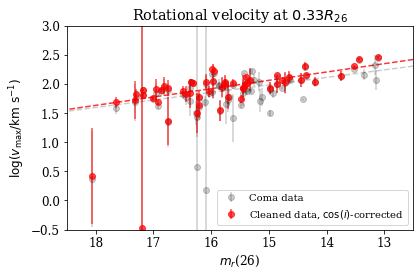

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)


################################################################################
# Original data
#-------------------------------------------------------------------------------
print('Original')

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.2,
            label='Coma data')

a, b, hess_inv = fit_3sigma(rmag[isrmeas], 
                            log10vmax[isrmeas], 
                            dlog10vmax[isrmeas])
print(a,b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'k--', alpha=0.2)
################################################################################


################################################################################
# Cleaned data
#-------------------------------------------------------------------------------
print('\nCleaned')

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b, hess_inv = fit_3sigma(rmag_clean[isrmeas_clean], 
                            log10vmax_clean[isrmeas_clean], 
                            dlog10vmax_clean[isrmeas_clean])
print(a,b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)
################################################################################


ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))

### Make pretty plot of just cleaned data with best fit

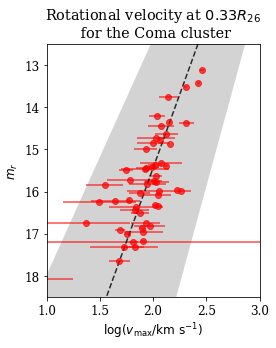

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4,5), tight_layout=True)

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean

r = np.arange(12.5,18.6,0.1)
v = a + b*r

################################################################################
# Compute and plot the uncertainty range around the best fit
#-------------------------------------------------------------------------------
hessian = ndt.Hessian(l1norm)
hess = hessian((a,b), 
               rmag_clean[isrmeas_clean], 
               log10vmax_clean[isrmeas_clean], 
               dlog10vmax_clean[isrmeas_clean])

N_samples = 1000

random_samples = np.random.multivariate_normal(mean=(a,b), 
                                               cov=np.linalg.inv(np.abs(hess)), #hess_inv.matmat(np.eye(2)), 
                                               size=N_samples)

y_samples = np.zeros([1000, len(r)])
for i in range(len(r)):
    y_samples[:,i] = random_samples[:,0] + random_samples[:,1]*r[i]

std_dev = np.std(y_samples, axis=0)

ax.fill_betweenx(r, v-std_dev, v+std_dev, facecolor='lightgray')
################################################################################

ax.plot(v, r, 'k--', alpha=0.8)

ax.errorbar(log10vmax_clean[isrmeas_clean], 
            rmag_clean[isrmeas_clean], 
            xerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7)

ax.set(ylabel='$m_r$',
       ylim=(18.5, 12.5),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       xlim=(1,3),
       title='Rotational velocity at $0.33R_{26}$ \n for the Coma cluster');

#plt.savefig('../Figures/PV_TFR_Coma_fitWOerrors_09262021.eps', format='eps', dpi=120);